# Dynamical analysis of Wilson-Cowan model

In [2]:
pip install -U brainpy-simulator

     |████████████████████████████████| 126 kB 7.7 MB/s 
  Created wheel for brainpy-simulator: filename=brainpy_simulator-1.0.2-py3-none-any.whl size=152106 sha256=2366e801ace9e1744d09b562f7db3d6d7509156de3077adcada910af123f929e
  Stored in directory: /root/.cache/pip/wheels/ec/1c/3f/e33093b69bc03ff9b2742480ec6126ddef875ba4f6d3699659
Successfully built brainpy-simulator


In [3]:
import brainpy as bp
import matplotlib.pyplot as plt
import numpy as np

from collections import OrderedDict

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
bp.backend.set('numba', dt=0.01)


The Wilson-Cowan equations model the mean-field (i.e., average across the population) dynamics of two coupled populations of excitatory (E) and inhibitory (I) neurons:

\begin{align}
&\tau_E \frac{dE}{dt} = -E + (1 - r E) F(w_{EE}E -w_{EI}I + I_{ext};a,\theta)\\
&\tau_I \frac{dI}{dt} = -I + (1 - r I) F(w_{IE}E -w_{II}I;a,\theta)
\end{align}

$E(t)$ represents the average activation of the excitatory population, and $I(t)$ the activation of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of each population. The connection strengths are given by: $w_{EE}$ (E to E), $w_{EI}$ (I to E), $w_{IE}$ (E to I), and $w_{II}$ (I to I). Refractory effects are modeled through the parameter $r$, and $I_{ext}$ represents external input to the excitatory population. 


The function $F$ describes the population activation function. We assume $F$ to be a sigmoidal function, which is parameterized by its gain $a$ and threshold $\theta$.

$$ F(x;a,\theta) = \frac{1}{1+\exp\{-a(x-\theta)\}} - \frac{1}{1+\exp\{a\theta\}}$$

The argument $x$ represents the input to the population. Note that the the second term is chosen so that $F(0;a,\theta)=0$. The model is intersting as it can generate rich dynamics of neuronal behavior as observed in experiments. Here we use it as an example to illustrate the math tools to analyze the long-time behavior of a dynamical system. 

To start, please execute the cell below to initialize the notebook environment.

In [6]:
# Connection weights
wEE = 12
wEI = 4
wIE = 13
wII = 11

# Refractory parameter
r = 1

# External input
I_ext = 0

# Excitatory parameters
tau_E = 1  # Timescale of excitatory population
a_E = 1.2  # Gain of excitatory population
theta_E = 2.8  # Threshold of excitatory population

# Inhibitory parameters
tau_I = 1  # Timescale of inhibitory population
a_I = 1  # Gain of inhibitory population
theta_I = 4  # Threshold of inhibitory population

In [16]:
class WilsonCowan(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  def __init__(self, size=1, **kwargs):
    super(WilsonCowan, self).__init__(size=size, **kwargs)
    self.E = np.zeros(self.num)
    self.I = np.zeros(self.num)
    self.input = np.zeros(self.num)
    
  @staticmethod
  @bp.odeint
  def integral(E, I, t, Iext):
    x_E = wEE * E - wEI * I + Iext
    F_E = 1 / (1 + np.exp(-a_E*(x_E-theta_E))) - 1 / (1 + np.exp(a_E*theta_E))
    dE = (-E + (1-r*E)*F_E ) / tau_E 
    x_I = wIE * E - wII * I
    F_I = 1 / (1 + np.exp(-a_I*(x_I-theta_I))) - 1 / (1 + np.exp(a_I*theta_I))
    dI = (-I + (1-r*I)*F_I ) / tau_I 
    return dE, dI

  def update(self, _t, ):
    self.E, self.I = self.integral(self.E, self.I, _t, self.input)
    self.input[:] = 0.

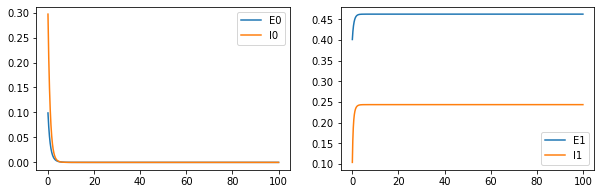

In [26]:
wc = WilsonCowan(2, monitors=['E', 'I'])
wc.E[:] = [0.1, 0.4]
wc.I[:] = [0.3, 0.1]

wc.run(100.)

plt.figure(figsize=(10, 3))
for i in range(wc.num):
    plt.subplot(1, wc.num, i+1)
    plt.plot(wc.mon.ts, wc.mon.E[:,i], label=f'E{i}')
    plt.plot(wc.mon.ts, wc.mon.I[:,i], label=f'I{i}')
    plt.legend()

$I_{ext} = 0.$

plot nullcline ...
SymPy solve "integral(E, I) = 0" to "I = f(E, )", failed because the equation is too complex.
SymPy solve "integral(E, I) = 0" to "E = f(I)", success.
SymPy solve "integral(E, I) = 0" to "I = f(E, )", success.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "integral(E, I)" by "E", success.
SymPy solve derivative of "integral(E, I)" by "I", success.
SymPy solve derivative of "integral(E, I)" by "E", success.
SymPy solve derivative of "integral(E, I)" by "I", success.
Fixed point #1 at E=0.0, I=0.0 is a stable node.
Fixed point #2 at E=2.3570888830503323e-15, I=4.440892098500626e-16 is a stable node.
Fixed point #3 at E=0.1780372586001967, I=0.06280117842559255 is a saddle node.
Fixed point #4 at E=0.4624648731609495, I=0.24336411278349315 is a stable node.


(array([0.00000000e+00, 2.35708888e-15, 1.78037259e-01, 4.62464873e-01]),
 array([0.00000000e+00, 4.44089210e-16, 6.28011784e-02, 2.43364113e-01]))

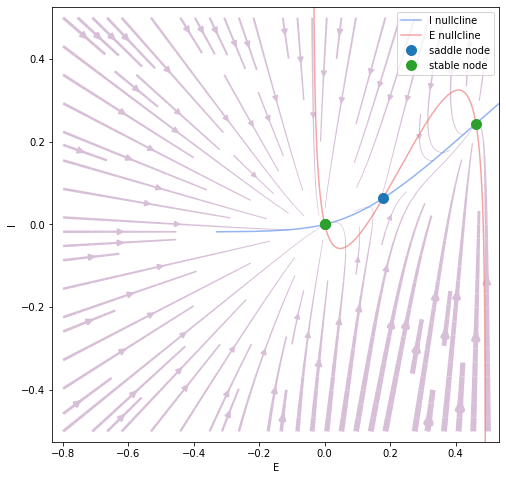

In [30]:
analyzer = bp.analysis.PhasePlane(
  integrals=wc.integral,
  target_vars=OrderedDict(E=[-0.8, 0.5], I=[-0.5, 0.5]),
  pars_update=dict(Iext=0.),
  numerical_resolution=0.001,
)
plt.figure(figsize=(8, 8))
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
# analyzer.plot_trajectory([{'E': 0.1, 'I': 0.3},{'E': 0.4, 'I': 0.1}], duration=20.)

$I_{ext} = 0.2$

plot nullcline ...
SymPy solve "integral(E, I) = 0" to "I = f(E, )", failed because the equation is too complex.
SymPy solve "integral(E, I) = 0" to "E = f(I)", success.
SymPy solve "integral(E, I) = 0" to "I = f(E, )", success.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "integral(E, I)" by "E", success.
SymPy solve derivative of "integral(E, I)" by "I", success.
SymPy solve derivative of "integral(E, I)" by "E", success.
SymPy solve derivative of "integral(E, I)" by "I", success.
Fixed point #1 at E=0.021709637288224084, I=0.004568844927794482 is a stable node.
Fixed point #2 at E=0.113370268494367, I=0.03335745907214995 is a saddle node.
Fixed point #3 at E=0.4702004971438942, I=0.24871539922513763 is a stable node.


(array([0.02170964, 0.11337027, 0.4702005 ]),
 array([0.00456884, 0.03335746, 0.2487154 ]))

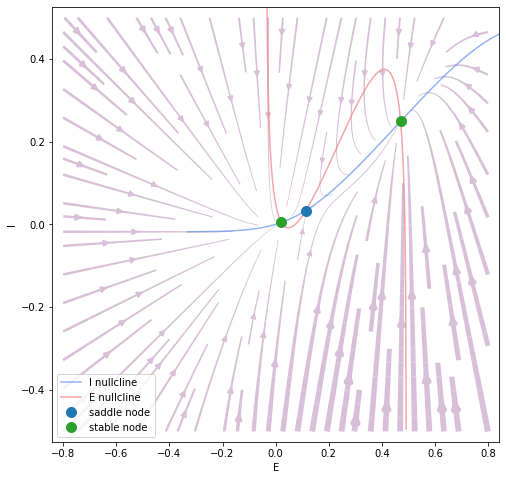

In [28]:
analyzer = bp.analysis.PhasePlane(
  integrals=wc.integral,
  target_vars=OrderedDict(E=[-0.8, 0.8], I=[-0.5, 0.5]),
  pars_update=dict(Iext=0.2),
  numerical_resolution=0.001,
)
plt.figure(figsize=(8, 8))
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()

$I_{ext} = 0.3$

plot nullcline ...
SymPy solve "integral(E, I) = 0" to "I = f(E, )", failed because the equation is too complex.
SymPy solve "integral(E, I) = 0" to "E = f(I)", success.
SymPy solve "integral(E, I) = 0" to "I = f(E, )", success.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "integral(E, I)" by "E", success.
SymPy solve derivative of "integral(E, I)" by "I", success.
SymPy solve derivative of "integral(E, I)" by "E", success.
SymPy solve derivative of "integral(E, I)" by "I", success.
Fixed point #1 at E=0.4730957303377093, I=0.2507174035079261 is a stable node.


(array([0.47309573]), array([0.2507174]))

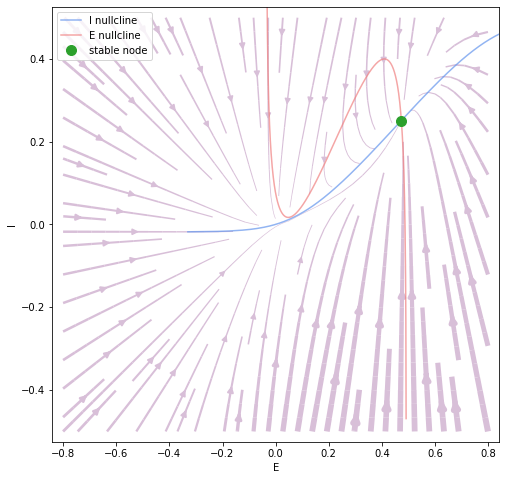

In [29]:
analyzer = bp.analysis.PhasePlane(
  integrals=wc.integral,
  target_vars=OrderedDict(E=[-0.8, 0.8], I=[-0.5, 0.5]),
  pars_update=dict(Iext=0.3),
  numerical_resolution=0.001,
)
plt.figure(figsize=(8, 8))
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
# analyzer.plot_trajectory([{'E': -0.2, 'I': -0.2},], duration=100.)